In [1]:
import matplotlib.pyplot as plt
import numpy as np

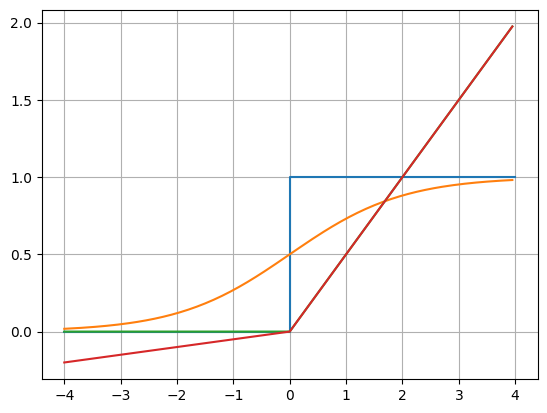

In [71]:
x = np.arange(-4, 4, 0.05)
y_small = np.arange(-2, 2, 0.025)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.where(x>0,x,0)

def leaky_relu(x):
    return np.where(x>0,x,0.1*x)


fig, ax = plt.subplots()
ax.grid()
ax.plot([-4, 0, 0, 4], [0, 0, 1, 1])
ax.plot(x, sigmoid(x))
ax.plot(x, relu(y_small))
ax.plot(x, leaky_relu(y_small))

plt.show()

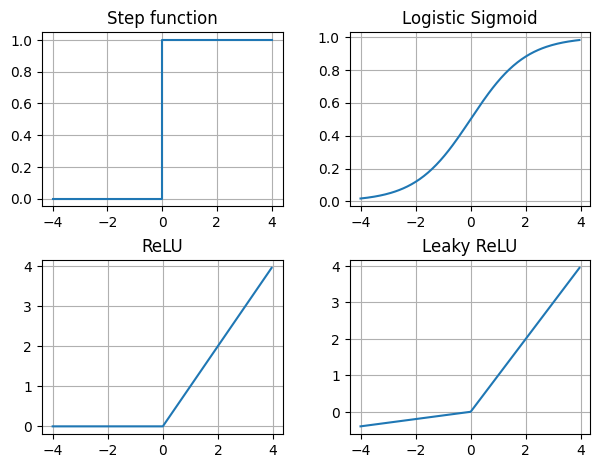

In [83]:
x = np.arange(-4, 4, 0.05)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.where(x>0,x,0)

def leaky_relu(x):
    return np.where(x>0,x,0.1*x)


fig, ax = plt.subplots(2, 2)
fig.tight_layout(pad=1.75)

ax[0, 0].grid()
ax[0, 0].plot([-4, 0, 0, 4], [0, 0, 1, 1])
ax[0, 0].set_title("Step function")

ax[0, 1].grid()
ax[0, 1].plot(x, sigmoid(x))
ax[0, 1].set_title("Logistic Sigmoid")

ax[1, 0].grid()
ax[1, 0].plot(x, relu(x))
ax[1, 0].set_title("ReLU")

ax[1, 1].grid()
ax[1, 1].plot(x, leaky_relu(x))
ax[1, 1].set_title("Leaky ReLU")

plt.show()